<a href="https://colab.research.google.com/github/TQT2203/BTVN-AI/blob/main/Bai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

# Đường dẫn đến file zip đã upload
zip_path = "/content/Bai2.zip"  # Đúng đường dẫn khi bạn upload

# Thư mục giải nén
extract_path = "/content/Bai2"

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Đã giải nén thành công!")


✅ Đã giải nén thành công!


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Thư mục chứa dữ liệu gốc sau khi giải nén
dataset_dir = "/content/Bai2"

# Thư mục đích chứa dữ liệu đã chia
output_dir = "/content/dataset"

# Tạo thư mục train/val và các lớp con
for split in ['train', 'val']:
    for category in ['dat_yeu_cau', 'khong_dat_yeu_cau']:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Chia dữ liệu
for category in ['dat_yeu_cau', 'khong_dat_yeu_cau']:
    category_path = os.path.join(dataset_dir, category)
    images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    train_imgs, val_imgs = train_test_split(images, test_size=0.3, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_dir, 'train', category, img))

    for img in val_imgs:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_dir, 'val', category, img))

print("✅ Đã chia tập train/val thành công!")

✅ Đã chia tập train/val thành công!


In [3]:
from PIL import Image
import numpy as np

IMG_SIZE = (640, 640)

def resize_and_normalize_image(image_path, output_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE, Image.Resampling.LANCZOS)
    img_array = np.array(img) / 255.0
    img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))
    img_normalized.save(output_path)

# Resize tất cả ảnh trong train/val
for split in ['train', 'val']:
    for category in ['dat_yeu_cau', 'khong_dat_yeu_cau']:
        folder = os.path.join(output_dir, split, category)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            if os.path.isfile(img_path):
                resize_and_normalize_image(img_path, img_path)

print("✅ Đã resize và chuẩn hóa ảnh thành công!")

✅ Đã resize và chuẩn hóa ảnh thành công!


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(640, 640, 3)),

    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# Thêm kiểm tra dữ liệu
class_weights = {0: 1., 1: 1.}  # Cân bằng nếu dataset bị mất cân bằng

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(640, 640),
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset/val',
    target_size=(640, 640),
    class_mode='binary'
)

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 640, 640, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 640, 640, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 640, 640, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 640, 640, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 320, 320, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 320, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 320, 320, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 320, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 160, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 160, 160, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 160, 160, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 160, 160, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 80, 80, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 80, 80, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 80, 80, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,472,033 (5.62 MB)

 Trainable params: 1,470,113 (5.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

Found 331 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 233s 13s/step - accuracy: 0.5330 - loss: 1.9019 - val_accuracy: 0.6364 - val_loss: 1.7551
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.6282 - loss: 1.7759 - val_accuracy: 0.6364 - val_loss: 1.7434
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.5834 - loss: 1.7145 - val_accuracy: 0.6364 - val_loss: 1.8029
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.6448 - loss: 1.6528 - val_accuracy: 0.6364 - val_loss: 2.0658
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6044 - loss: 1.6006 - val_accuracy: 0.6364 - val_loss: 2.1190
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.6040 - loss: 1.5535 - val_accuracy: 0.6364 - val_loss: 1.6422
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6601 - loss: 1.4939 - val_accuracy: 0.6364 - val_loss: 1.4928
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.5989 - loss: 1.4871 - val_accuracy: 0.6364 - val_los

In [5]:
model.save('bai2.h5')

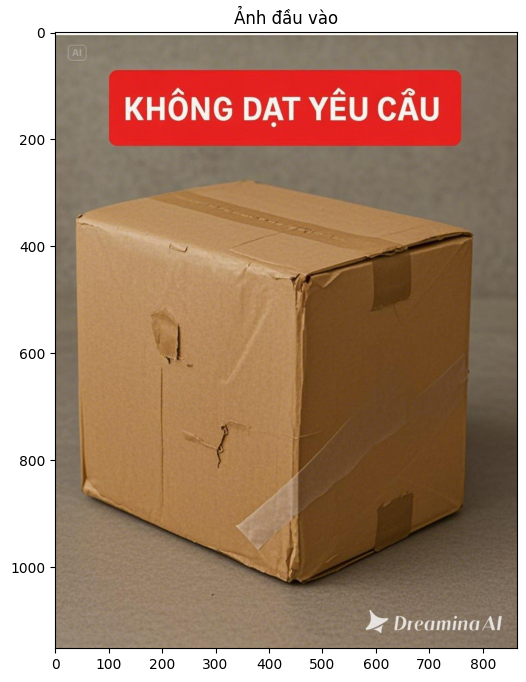

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Loại thùng giấy: Không đạt yêu cầu


In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

image_path = r"/content/khongdat.jpeg"
img = cv2.imread(image_path)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh đầu vào')
plt.show()

if img is None:
    print("Không thể đọc hình ảnh. Vui lòng kiểm tra đường dẫn:", image_path)
else:
    img = cv2.resize(img, (640, 640))

    img = img / 255.0

    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)

    if prediction[0] > 0.5:
        print("Loại thùng giấy: Đạt yêu cầu")
    else:
        print("Loại thùng giấy: Không đạt yêu cầu")


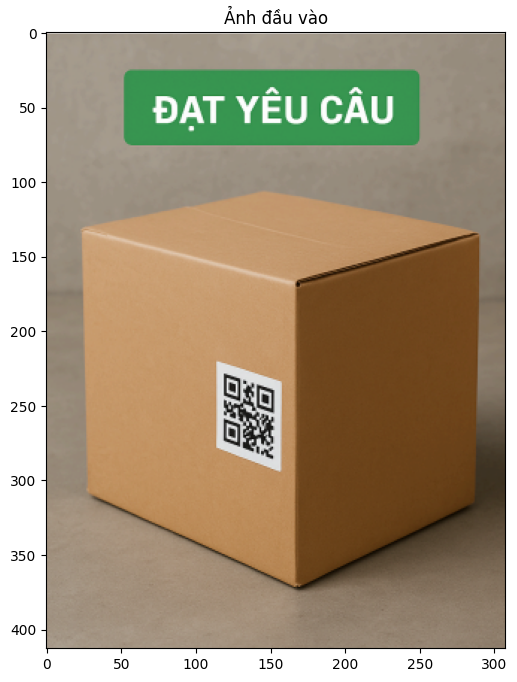

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Loại thùng giấy: Đạt yêu cầu
Xác suất (đạt yêu cầu): 0.4500


In [17]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

image_path = r"/content/dat.png"
img = cv2.imread(image_path)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh đầu vào')
plt.show()

if img is None:
    print("Không thể đọc hình ảnh. Vui lòng kiểm tra đường dẫn:", image_path)
else:
    img = cv2.resize(img, (640, 640))

    img = img / 255.0

    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)

    if prediction[0] > 0.45:
        print("Loại thùng giấy: Đạt yêu cầu")
    else:
        print("Loại thùng giấy: Không đạt yêu cầu")

    print(f"Xác suất (đạt yêu cầu): {prediction[0][0]:.4f}")